# Time Series

### Modules

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn import base

In [60]:
df_org = pd.read_csv("data\Sales_Transactions_Dataset_Weekly.csv")
df_org = df_org.filter(regex=r'Product|W')
df_org.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [62]:
df = df_org.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

df['Product_Code'] = df['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
df['Week'] = df['Week'].str.extract('(\d+)', expand=False).astype(int)

df = df.sort_values(['Week', 'Product_Code'])
df.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


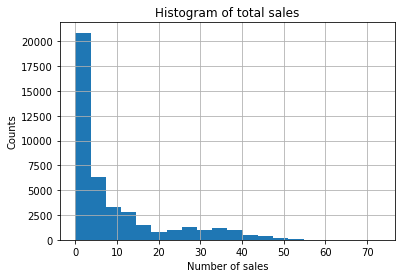

In [63]:
fig, ax = plt.subplots(figsize=(6,4))
df.hist(column='Sales', bins=20, ax=ax)
ax.set_title("Histogram of total sales")
ax.set_xlabel("Number of sales")
ax.set_ylabel("Counts")
plt.show()

In [79]:
class ToSupervised(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col, groupCol, numLags, dropna=False):
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        tmp = self.X.copy()

        for i in range(1, self.numLags+1):
            tmp[str(i) + '_Week_Ago_' + self.col] = tmp.groupby([self.groupCol])[self.col].shift(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
        
        return tmp

In [78]:

class ToSupervisedDiff(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, col, groupCol, numLags, dropna=False):
        self.col = col
        self.groupCol = groupCol
        self.numLags = numLags
        self.dropna = dropna
        
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def transform(self, X):
        tmp = self.X.copy()

        for i in range(1, self.numLags+1):
            tmp[str(i)+'_Week_Ago_Diff_'+self.col] = tmp.groupby([self.groupCol])[self.col].diff(i) 
            
        if self.dropna:
            tmp = tmp.dropna()
            tmp = tmp.reset_index(drop=True)
            
        return tmp

In [80]:
steps = [
    ('1_step', ToSupervised('Sales', 'Product_Code', 1)),
    ('1_step_diff', ToSupervisedDiff('1_Week_Ago_Sales', 'Product_Code', 1, dropna=True))
]

super_1 = Pipeline(steps, verbose=True).fit_transform(df)

[Pipeline] ............ (step 1 of 2) Processing 1_step, total=   0.0s
[Pipeline] ....... (step 2 of 2) Processing 1_step_diff, total=   0.4s


In [81]:
super_1

,Product_Code,Week,Sales,1_Week_Ago_Sales,1_Week_Ago_Diff_1_Week_Ago_Sales
0,1,2,10,12.0,1.0
1,2,2,3,6.0,-1.0
2,3,2,8,11.0,4.0
3,4,2,13,8.0,-4.0
4,5,2,13,5.0,-3.0
...,...,...,...,...,...
40545,815,51,0,2.0,2.0
40546,816,51,5,6.0,1.0
40547,817,51,3,4.0,4.0
40548,818,51,0,2.0,2.0


In [82]:
from itertools import chain
class Kfold_time(object):
    
    def __init__(self,**options):
        
        self.target     = options.pop('target', None)
        self.date_col   = options.pop('date_col', None)
        self.date_init  = options.pop('date_init', None)
        self.date_final = options.pop('date_final', None)

        if options:
            raise TypeError("Invalid parameters passed: %s" % str(options))
            
        if ((self.target==None )|(self.date_col==None )|(self.date_init==None )|(self.date_final==None)):
            raise TypeError("Incomplete inputs")
    
    def _train_test_split_time(self, X):
        n_arrays = len(X)
        if n_arrays == 0:
            raise ValueError("At least one array required as input")

        for i in range(self.date_init, self.date_final):

            train = X[X[self.date_col] < i]
            val   = X[X[self.date_col] == i]

            X_train, X_test = train.drop([self.target], axis=1), val.drop([self.target], axis=1)
            y_train, y_test = train[self.target].values, val[self.target].values

            yield X_train, X_test, y_train, y_test

    
    def split(self, X):
        cv_t = self._train_test_split_time(X)
        return chain(cv_t)

In [83]:
kf = Kfold_time(target='Sales', date_col = 'Week', date_init=40, date_final=52)

In [87]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [89]:
class BaseEstimator(base.BaseEstimator, base.RegressorMixin):
    def __init__(self, predCol):
        """
            As a base model we assume the number of sales last week and this week are the same
            Input: 
                    predCol: l-week ago sales
        """
        self.predCol = predCol

        
    def fit(self, X, y):
        return self


    def predict(self, X):
        prediction = X[self.predCol].values
        return prediction

    def score(self, X, y, scoring):
        prediction = self.predict(X)
        error = scoring(y, prediction)# np.sqrt(mean_squared_log_error(y, prediction))
        return error

In [90]:
base_model = BaseEstimator('1_Week_Ago_Sales')
errors = []

for indx, fold in enumerate(kf.split(super_1)):
    X_train, X_test, y_train, y_test = fold
    error = base_model.score(X_test, y_test, rmsle)
    errors.append(error)
    print("Fold: {}, Error: {:.3f}".format(indx, error))
    
print('Total Error {:.3f}'.format(np.mean(errors)))

Fold: 0, Error: 0.520
Fold: 1, Error: 0.517
Fold: 2, Error: 0.510
Fold: 3, Error: 0.508
Fold: 4, Error: 0.534
Fold: 5, Error: 0.523
Fold: 6, Error: 0.500
Fold: 7, Error: 0.491
Fold: 8, Error: 0.506
Fold: 9, Error: 0.505
Fold: 10, Error: 0.522
Fold: 11, Error: 0.552
Total Error 0.516


In [92]:
class TimeSeriesRegressor(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, model, cv, scoring, verbosity=True):
        self.model = model
        self.cv = cv
        self.scoring = scoring 
        self.verbosity = verbosity
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):
            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction
    

    def score(self,X,y=None):
        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            prediction = self.model.predict(X_test)
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
            print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

In [94]:
model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)

steps_1 = [('1_step', ToSupervised('Sales', 'Product_Code', 1)),
           ('1_step_diff', ToSupervisedDiff('1_Week_Ago_Sales', 'Product_Code', 1, dropna=True)),
           ('predic_1', TimeSeriesRegressor(model=model, cv=kf, scoring=rmsle))]

super_1_p = Pipeline(steps_1, verbose=True).fit(df)
Model_1_Error = super_1_p.score(df)

Fold: 0, Error: 0.4624
Fold: 1, Error: 0.4596
Fold: 2, Error: 0.4617
Fold: 3, Error: 0.4666
Fold: 4, Error: 0.4712
Fold: 5, Error: 0.4310
Fold: 6, Error: 0.4718
Fold: 7, Error: 0.4494
Fold: 8, Error: 0.4608
Fold: 9, Error: 0.4470
Fold: 10, Error: 0.4746
Fold: 11, Error: 0.4865
Total Error 0.4619


In [96]:
steps_3 = [('1_step', ToSupervised('Sales', 'Product_Code', 3)),
           ('1_step_diff', ToSupervisedDiff('1_Week_Ago_Sales', 'Product_Code', 1)),
           ('2_step_diff', ToSupervisedDiff('2_Week_Ago_Sales', 'Product_Code', 1)),
           ('3_step_diff', ToSupervisedDiff('3_Week_Ago_Sales', 'Product_Code', 1, dropna=True)),
           ('predic_3', TimeSeriesRegressor(model=model, cv=kf, scoring=rmsle))]
super_3_p = Pipeline(steps_3, verbose=True).fit(df)
Model_3_Error = super_3_p.score(df)

[Pipeline] ............ (step 1 of 5) Processing 1_step, total=   0.0s
[Pipeline] ....... (step 2 of 5) Processing 1_step_diff, total=   0.7s
[Pipeline] ....... (step 3 of 5) Processing 2_step_diff, total=   0.3s
[Pipeline] ....... (step 4 of 5) Processing 3_step_diff, total=   0.3s
[Pipeline] .......... (step 5 of 5) Processing predic_3, total=   0.0s
Fold: 0, Error: 0.4312
Fold: 1, Error: 0.4385
Fold: 2, Error: 0.4274
Fold: 3, Error: 0.4194
Fold: 4, Error: 0.4479
Fold: 5, Error: 0.4070
Fold: 6, Error: 0.4395
Fold: 7, Error: 0.4333
Fold: 8, Error: 0.4387
Fold: 9, Error: 0.4305
Fold: 10, Error: 0.4591
Fold: 11, Error: 0.4534
Total Error 0.4355


In [98]:
class TimeSeriesRegressorLog(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,model,cv,scoring,verbosity=True):
        self.model = model
        self.cv = cv
        self.verbosity = verbosity
        self.scoring = scoring
        
            
    def fit(self,X,y=None):
        return self
        
    
    def predict(self,X=None):
        
        pred = {}
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, y_train)
            pred[str(indx)+'_fold'] = self.model.predict(X_test)
            
        prediction = pd.DataFrame(pred)
    
        return prediction

    
    def score(self,X,y=None):#**options):


        errors = []
        for indx,fold in enumerate(self.cv.split(X)):

            X_train, X_test, y_train, y_test = fold    
            self.model.fit(X_train, np.log1p(y_train))
            prediction = np.expm1(self.model.predict(X_test))
            error = self.scoring(y_test, prediction)
            errors.append(error)

            if self.verbosity:
                print("Fold: {}, Error: {:.4f}".format(indx,error))

        if self.verbosity:
                print('Total Error {:.4f}'.format(np.mean(errors)))

        return errors

In [99]:
model_lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
steps_3_log_lgbm = [('1_step', ToSupervised('Sales','Product_Code', 3)),
                    ('1_step_diff', ToSupervisedDiff('1_Week_Ago_Sales', 'Product_Code', 1)),
                    ('2_step_diff', ToSupervisedDiff('2_Week_Ago_Sales', 'Product_Code', 1)),
                    ('3_step_diff', ToSupervisedDiff('3_Week_Ago_Sales', 'Product_Code', 1,  dropna=True)),
                    ('predic_3', TimeSeriesRegressorLog(model=model_lgb, cv=kf, scoring=rmsle))]

super_3_p_log_lgbm = Pipeline(steps_3_log_lgbm, verbose=True).fit(df)

[Pipeline] ............ (step 1 of 5) Processing 1_step, total=   0.1s
[Pipeline] ....... (step 2 of 5) Processing 1_step_diff, total=   0.5s
[Pipeline] ....... (step 3 of 5) Processing 2_step_diff, total=   0.4s
[Pipeline] ....... (step 4 of 5) Processing 3_step_diff, total=   0.4s
[Pipeline] .......... (step 5 of 5) Processing predic_3, total=   0.0s


In [107]:
def getDataFramePipeline(i):
    steps = [(str(i)+'_step',ToSupervised('Sales','Product_Code',i))]
    for j in range(1,i+1):
        if i==j:

            pp = (str(j)+'_step_diff',
                  ToSupervisedDiff(str(i)+'_Week_Ago_Sales','Product_Code',1,dropna=True))
            steps.append(pp)
        else:

            pp = (str(j)+'_step_diff',
                  ToSupervisedDiff(str(i)+'_Week_Ago_Sales','Product_Code',1))
            steps.append(pp)
            
    return steps
            

In [108]:
from tqdm import tqdm
def stepsTune(X, model, num_steps, init=1):
    scores = []
    for i in tqdm(range(init,num_steps+1)):
        steps = []
        steps.extend(getDataFramePipeline(i))
        steps.append(('predic_1',model))
        super_ = Pipeline(steps).fit(X)
        score_ = np.mean(super_.score(X))
        scores.append((i,score_))
        
    return scores

In [109]:
model_lgbm = LGBMRegressor(n_estimators=1000, learning_rate=0.01)
list_scores2 = stepsTune(df, TimeSeriesRegressorLog(model=model_lgbm, scoring=rmsle, cv=kf, verbosity=False),num_steps=20)

 90%|█████████ | 18/20 [14:45<01:38, 49.17s/it]


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [104]:
from collections.abc import Mapping, Sequence, Iterable
from itertools import product
from functools import partial, reduce
import operator

class TimeGridBasic(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self,param_grid):
        
    
        if not isinstance(param_grid, (Mapping, Iterable)):
                raise TypeError('Parameter grid is not a dict or '
                                'a list ({!r})'.format(param_grid))

        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]


        if isinstance(param_grid, Mapping):
                # wrap dictionary in a singleton list to support either dict
                # or list of dicts
                param_grid = [param_grid]

        # check if all entries are dictionaries of lists
        for grid in param_grid:
            if not isinstance(grid, dict):
                raise TypeError('Parameter grid is not a '
                                'dict ({!r})'.format(grid))
            for key in grid:
                if not isinstance(grid[key], Iterable):
                    raise TypeError('Parameter grid value is not iterable '
                                    '(key={!r}, value={!r})'
                                    .format(key, grid[key]))


        self.param_grid = param_grid
                
    def __iter__(self):
        """Iterate over the points in the grid.
        Returns
        -------
        params : iterator over dict of string to any
            Yields dictionaries mapping each estimator parameter to one of its
            allowed values.
        """
        for p in self.param_grid:
            # Always sort the keys of a dictionary, for reproducibility
            items = sorted(p.items())
            if not items:
                yield {}
            else:
                keys, values = zip(*items)
                for v in product(*values):
                    params = dict(zip(keys, v))
                    yield params